In [1]:
import drag_functions_turb as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from time_TvsR import *
import scipy.optimize as opt
import os
import sys

%matplotlib inline
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.borderpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 18
#mpl.rcParams['legend.numpoints'] = 1
plt.rc('lines', linewidth=3)
colors = ['4D4D4D','5DA5DA', 'FAA43A', '60BD68', 'F17CB0','B2912F','B276B2','DECF3F','F15854']
                                #  (blue)
                                # (orange)
                                # (green)
                                # (pink)
                                #  (brown)
                                # (purple)
                                #  (yellow)
                                # (red)
                                # ']
#mpl.rcParams['axes.color_cycle'] = colors

# Solution for $t^*$

In [2]:
def y_str_eqn(y_str,st):
    """Equation 21d from OC07 with term on RHS subtracted over. Ignores V_0 term following text,
    which we may want to include later."""
    return 2./3. * y_str * (y_str - 1.)**2. - (1 + y_str)**(-1.) + (1 + st**(-1.))**(-1.)

In [3]:
def st_str(st):
    """Function to solve for t_* following OC07 21d. Ignores V_0 term. """
    if st>=1:
        return 1. #Don't allow t_* > t_L
    else:
        return opt.fsolve(y_str_eqn,st,args=(st))[0]*st

In [4]:
x=opt.fsolve(y_str_eqn,1e-1,args=(1e-4))[0]
x

1.6003088991856713

In [5]:
#Make sure that function works by reproducing OC07 Fig. 2

pnts = 100
st_arr = np.logspace(-2,2,num=pnts)
sol_arr = np.zeros(pnts)

for i,st in enumerate(st_arr):
    sol_arr[i] = st_str(st)

[0.04, 10.0, 0.1, 2.0]

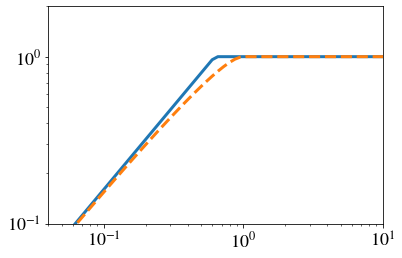

In [6]:
#OC07 Figure 2.
plt.loglog(st_arr,np.minimum(1.6*st_arr,1))
plt.loglog(st_arr,sol_arr,linestyle='dashed')
plt.axis([4e-2,1e1,1e-1,2e0])

# Solution for $\Delta V_{12}^2$

In [7]:
#Test the implementation
t_1 = 0.5
t_2 = 0.5
t_L = 1.
Re = 1e8
t_eta = Re**(-0.5)*t_L

t_1_str = st_str(t_1)
t_2_str = st_str(t_2)
t_12_str = max(t_1_str,t_2_str)

term_1 = (t_12_str + t_1**2./(t_1 + t_12_str) - (t_eta + t_1**2./(t_1 + t_eta))) +\
            ( (t_2 - t_1)/(t_1 + t_2) * (t_1**2./(t_1 + t_L) - t_1**2./(t_1 + t_12_str)) )
    
term_2 = (t_12_str + t_2**2./(t_2 + t_12_str) - (t_eta + t_2**2./(t_2 + t_eta))) +\
            ( (t_1 - t_2)/(t_2 + t_1) * (t_2**2./(t_2 + t_L) - t_2**2./(t_2 + t_12_str)) )

d_V = np.sqrt(term_1 + term_2)

In [8]:
d_V #Looks reasonable

0.8709184343760654

In [9]:
def d_V_12(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """Function for reproducing Eqn. (16) in OC07. Might need to add more input parameters"""
    
    t_eta = Re**(-0.5)*t_L
    
    t_1_str = st_str(t_1)
    t_2_str = st_str(t_2)
    t_12_str = max(t_1_str,t_2_str)
    t_12_str = max(t_12_str,t_eta)

    term_1 = (t_12_str + t_1**2./(t_1 + t_12_str) - (t_eta + t_1**2./(t_1 + t_eta))) +\
                ( (t_2 - t_1)/(t_1 + t_2) * (t_1**2./(t_1 + t_L) - t_1**2./(t_1 + t_12_str)) )

    term_2 = (t_12_str + t_2**2./(t_2 + t_12_str) - (t_eta + t_2**2./(t_2 + t_eta))) +\
                ( (t_1 - t_2)/(t_2 + t_1) * (t_2**2./(t_2 + t_L) - t_2**2./(t_2 + t_12_str)) )

    return np.sqrt(term_1 + term_2)

In [10]:
def d_V_small(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """OC07 Eqn. (27)"""
    t_eta = Re**(-0.5)*t_L
    
    st_1 = t_1/t_L
    st_2 = t_2/t_L
    
    return np.sqrt(t_L/t_eta)*(st_1 - st_2)

In [11]:
def d_V_med(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """OC07 Eqn. (28), assumes t_1 > t_2."""
    st_1 = t_1/t_L

    y_a = 1.6
    eta = t_2/t_1
    
    return np.sqrt( (2*y_a - (1 + eta) + 2/(1 + eta) * ( (1 + y_a)**(-1.) + eta**3./(y_a + eta) ) )*st_1 )

In [12]:
def d_V_large(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """OC07 Eqn. (29), assumes t_1 > t_2."""
    st_1 = t_1/t_L
    st_2 = t_2/t_L
    
    return np.sqrt( (1+st_1)**(-1.) + (1+st_2)**(-1.) )

In [13]:
def d_V_approx(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """Piecewise function for approximate regimes"""
    
    t_eta = Re**(-0.5)*t_L
    
    if t_1 < t_eta:
        return d_V_small(t_1=t_1, t_2 = t_2, t_L = t_L, Re = Re)
    elif t_1 < t_L:
        return d_V_med(t_1=t_1, t_2 = t_2, t_L = t_L, Re = Re)
    else:
        return d_V_large(t_1=t_1, t_2 = t_2, t_L = t_L, Re = Re)

In [14]:
#Reproduce OC07 Figure 3.
pnts = 500
st_arr = np.logspace(-5,1,num=pnts)
d_V_eq_arr = np.zeros(pnts)
d_V_eq_approx_arr = np.zeros(pnts)
d_V_diff_arr = np.zeros(pnts)
d_V_diff_approx_arr = np.zeros(pnts)

t_L = 1.
Re = 1e8

for i,st in enumerate(st_arr):
    t_1 = st*t_L
    t_2_eq = t_1
    t_2_diff = t_1*1e-4
    
    d_V_eq_arr[i] = d_V_12(t_1=t_1, t_2 = t_2_eq, t_L = t_L, Re = Re)
    d_V_diff_arr[i] = d_V_12(t_1=t_1, t_2 = t_2_diff, t_L = t_L, Re = Re)
    d_V_eq_approx_arr[i] = d_V_approx(t_1=t_1, t_2 = t_2_eq, t_L = t_L, Re = Re)
    d_V_diff_approx_arr[i] = d_V_approx(t_1=t_1, t_2 = t_2_diff, t_L = t_L, Re = Re)

/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


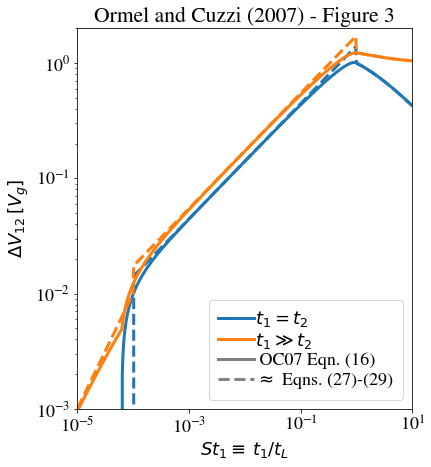

In [15]:
fig = plt.figure(1,figsize=(6,7))
line, = plt.loglog(st_arr,d_V_eq_arr,label=r'$t_1 = t_2$')
plt.loglog(st_arr,d_V_eq_approx_arr,linestyle='dashed',color=line.get_color())

line, = plt.loglog(st_arr,d_V_diff_arr,label=r'$t_1 \gg t_2$')
plt.loglog(st_arr,d_V_diff_approx_arr,linestyle='dashed',color=line.get_color())

plt.axis([1e-5,1e1,1e-3,2e0])

plt.xlabel(r"$St_1 \equiv \, t_1/t_L$")
plt.ylabel(r"$\Delta V_{12} \, [V_g]$")
plt.title("Ormel and Cuzzi (2007) - Figure 3")

ax = plt.gca()
ax.autoscale(False)

plt.plot(-100,-100,color='0.5',label=" OC07 Eqn. (16)")
plt.plot(-100,-100,color='0.5',linestyle='dashed',label=r"$\approx$ Eqns. (27)-(29)")

ax.legend(loc='best',fancybox=True)

### How accurate is this when $t_1 \gtrsim t_2$ but not $t_1 \gg t_2$?

In [16]:
#Reproduce OC07 Figure 3.
pnts = 500
st_arr = np.logspace(-5,1,num=pnts)
d_V_eq_arr = np.zeros(pnts)
d_V_exact_arr = np.zeros(pnts)
d_V_approx_arr = np.zeros(pnts)

t_L = 1.
Re = 1e8

for i,st in enumerate(st_arr):
    t_1 = st*t_L
    t_2 = t_1*0.1
    
    d_V_exact_arr[i] = d_V_12(t_1=t_1, t_2 = t_2, t_L = t_L, Re = Re)
    d_V_approx_arr[i] = d_V_approx(t_1=t_1, t_2 = t_2, t_L = t_L, Re = Re)

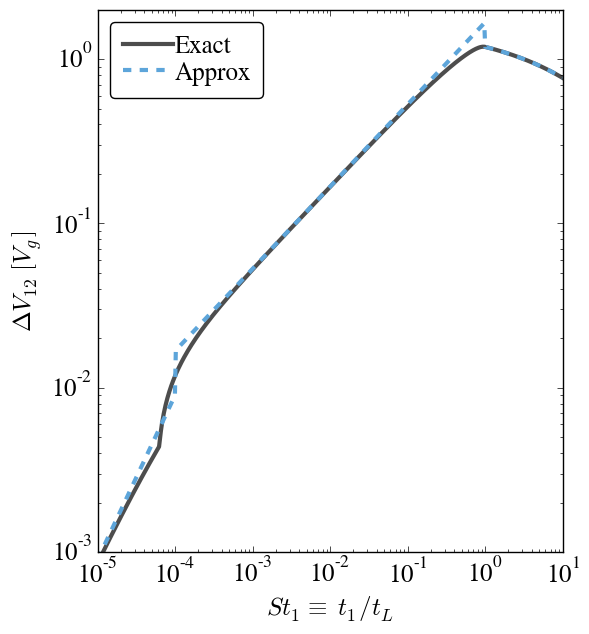

In [168]:
fig = plt.figure(1,figsize=(6,7))
plt.loglog(st_arr,d_V_exact_arr,label="Exact")
plt.loglog(st_arr,d_V_approx_arr,linestyle='dashed',label="Approx")

plt.axis([1e-5,1e1,1e-3,2e0])

plt.xlabel(r"$St_1 \equiv \, t_1/t_L$")
plt.ylabel(r"$\Delta V_{12} \, [V_g]$")
# plt.title("Ormel and Cuzzi (2007) - Figure 3")

ax = plt.gca()
# ax.autoscale(False)

# plt.plot(-100,-100,color='0.5',label=" OC07 Eqn. (16)")
# plt.plot(-100,-100,color='0.5',linestyle='dashed',label=r"$\approx$ Eqns. (27)-(29)")

ax.legend(loc='best',fancybox=True)